# BTC Strategy Design
***
## Import Package and Route

In [1]:
from datetime import datetime
from reference.Strategy import zwpy_sta
import pathlib
import backtrader as bt
import pyfolio as pf
import pandas as pd
import json
import backtrader.analyzers as btanalyzers

# route init
curr_folder = pathlib.Path().cwd()
BTC_data_min = curr_folder / "data" / "BTCUSDT_UPERP_1m.csv"

# report folder init
report_folder = curr_folder / "report"
if not report_folder.exists():
    report_folder.mkdir(parents=True, exist_ok=True)

data_folder = curr_folder / "data"
if not data_folder.exists():
    data_folder.mkdir(parents=True, exist_ok=True)



/home/thomas/Desktop/BTC/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## Data Resample

In [2]:
BTC_data_min = pd.read_csv(BTC_data_min, parse_dates =["datetime"], index_col ="datetime")
print("Minute ohlc\n", BTC_data_min.head(10))
BTC_data = BTC_data_min.resample('h').mean()
print("\nHour ohlc\n", BTC_data.head(10))
BTC_data.to_csv(str(data_folder / "BTC_hour.csv"))
BTC_data = pathlib.Path().cwd() / "data" / "BTC_hour.csv"

Minute ohlc
                         open     high      low    close  volume
datetime                                                       
2019-09-25 15:44:00  8323.22  8348.51  8323.22  8345.08  15.878
2019-09-25 15:45:00  8346.57  8348.32  8339.09  8339.09  15.931
2019-09-25 15:46:00  8340.21  8341.79  8320.05  8320.77  29.408
2019-09-25 15:47:00  8320.77  8338.87  8320.77  8336.79  40.464
2019-09-25 15:48:00  8336.79  8342.28  8329.25  8340.73  34.654
2019-09-25 15:49:00  8343.46  8343.89  8338.15  8343.86  33.772
2019-09-25 15:50:00  8341.07  8364.00  8341.07  8360.93  43.837
2019-09-25 15:51:00  8359.17  8379.33  8352.64  8374.18  43.769
2019-09-25 15:52:00  8375.08  8380.26  8367.21  8374.61  55.568
2019-09-25 15:53:00  8374.02  8374.02  8343.37  8346.06  26.116

Hour ohlc
                             open         high          low        close  \
datetime                                                                  
2019-09-25 15:00:00  8343.848750  8353.017500  8334.82062

## Optimize params
***
### Cutting row data Take 2021-01-01 as the boundary

In [ ]:
train = BTC_data[BTC_data.index < '2021-01-01 0:00:00']
test = BTC_data[BTC_data.index >= '2021-01-01 0:00:00']
train.to_csv(data_folder / "training_set.csv")
test.to_csv(data_folder / "testing_set.csv")

## Add strategy & initialize cerebro 
### 策略概要說明
    Rule:
        If MACD - MACD_signal > 0: buy.
        If MACD - MACD_signal < 0: sell.

    Args:
        fast_period (int): fast ema period.
        slow_period (int): slow ema period.
        signal_period (int): macd signal period.

In [4]:
# 實體化 cerebro 物件
cerebro = bt.Cerebro()

# 添加策略 策略檔位置('./reference/Strategy/zwpy_sta.py'class MacdV2Strategy)
cerebro.addstrategy(zwpy_sta.MacdV2Strategy)

#設置初始資金 100000
cerebro.broker.setcash(100000)

## Data format & Feed (backtrader)

In [6]:
dt_start = datetime.strptime("2019-09-25","%Y-%m-%d")
dt_end = datetime.strptime("2021-10-28","%Y-%m-%d")
data = bt.feeds.GenericCSVData(
    timeframe = bt.TimeFrame.Minutes,
    compression = 60,
    dataname=BTC_data,
    fromdate=dt_start,      
    todate=dt_end,
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S'),   
    datetime=0,             # 各列的位置，从0开始，如列缺失则为None，-1表示自动根据列名判断
    open = 1,
    high = 2,
    low = 3,
    close = 4,
    openinterest=-1,
    volume = -1
)
cerebro.adddata(data)

## Run Backtrader

Starting Value: 100000.00
printlog: False
period_me1: 12
period_me2: 26
period_signal: 9
=== Backtesting Start! ===
=== Backtesting Finished! ===
Ending Value: 152852.72


<IPython.core.display.Javascript object>


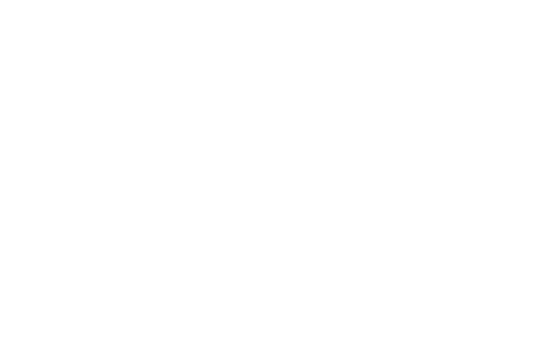

[[<Figure size 432x288 with 5 Axes>]]

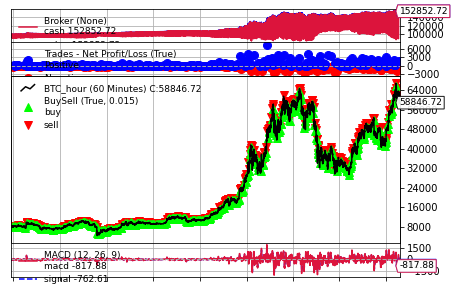

In [7]:
print('Starting Value: %.2f' % cerebro.broker.getvalue())

# 添加pyfolio analyzers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Ending Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot()

## Pyfolio 計算風險指標

Start date,2019-09-25
End date,2021-10-28
Total months,36
,Backtest
Annual return,15.001%
Cumulative returns,52.853%
Annual volatility,9.15%
Sharpe ratio,1.57
Calmar ratio,2.13
Stability,0.87
Max drawdown,-7.04%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.04,2021-03-15,2021-04-27,2021-08-21,115
1,4.82,2021-01-14,2021-02-01,2021-02-08,18
2,4.31,2021-02-22,2021-02-28,2021-03-05,10
3,2.57,2021-08-23,2021-09-01,2021-10-06,33
4,2.48,2021-01-07,2021-01-13,2021-01-14,6


<IPython.core.display.Javascript object>


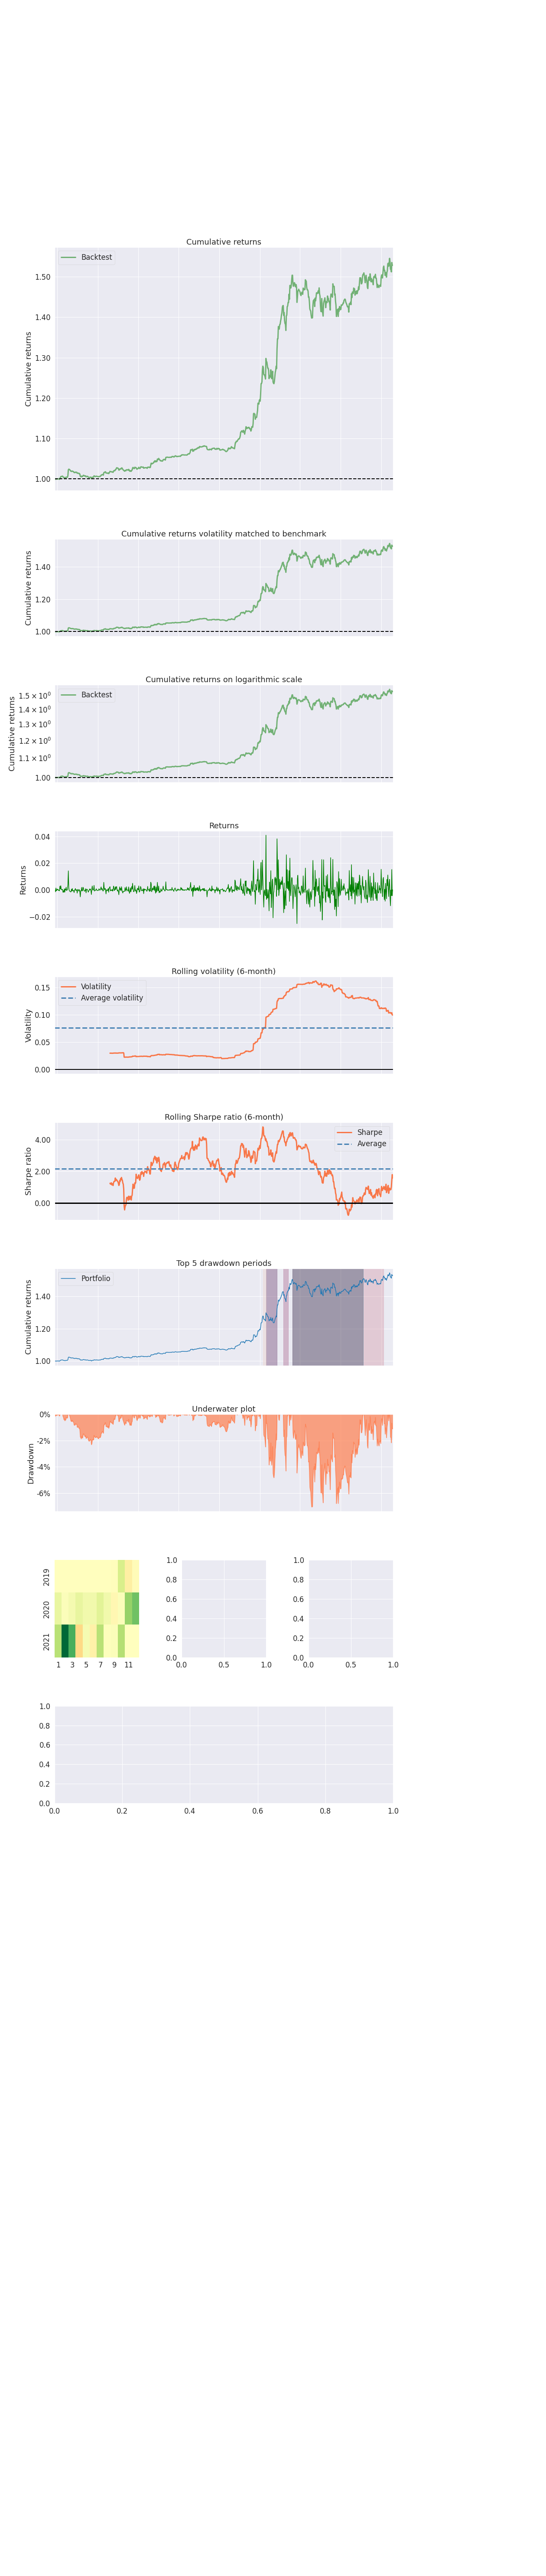

/home/thomas/Desktop/BTC/env/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,0.06%,-2.52%,4.09%


<IPython.core.display.Javascript object>


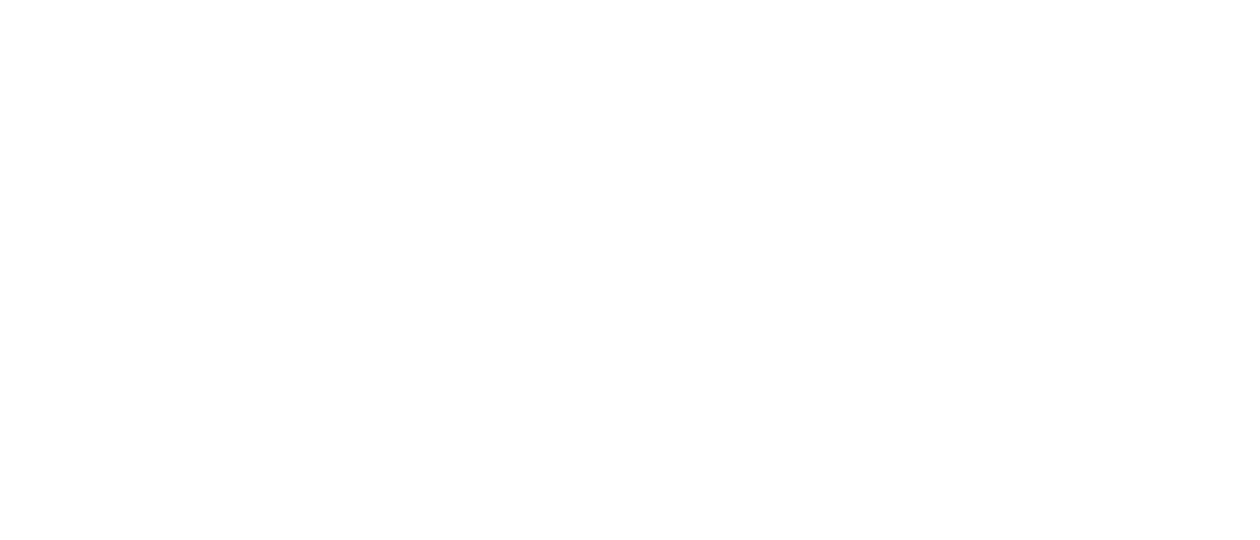

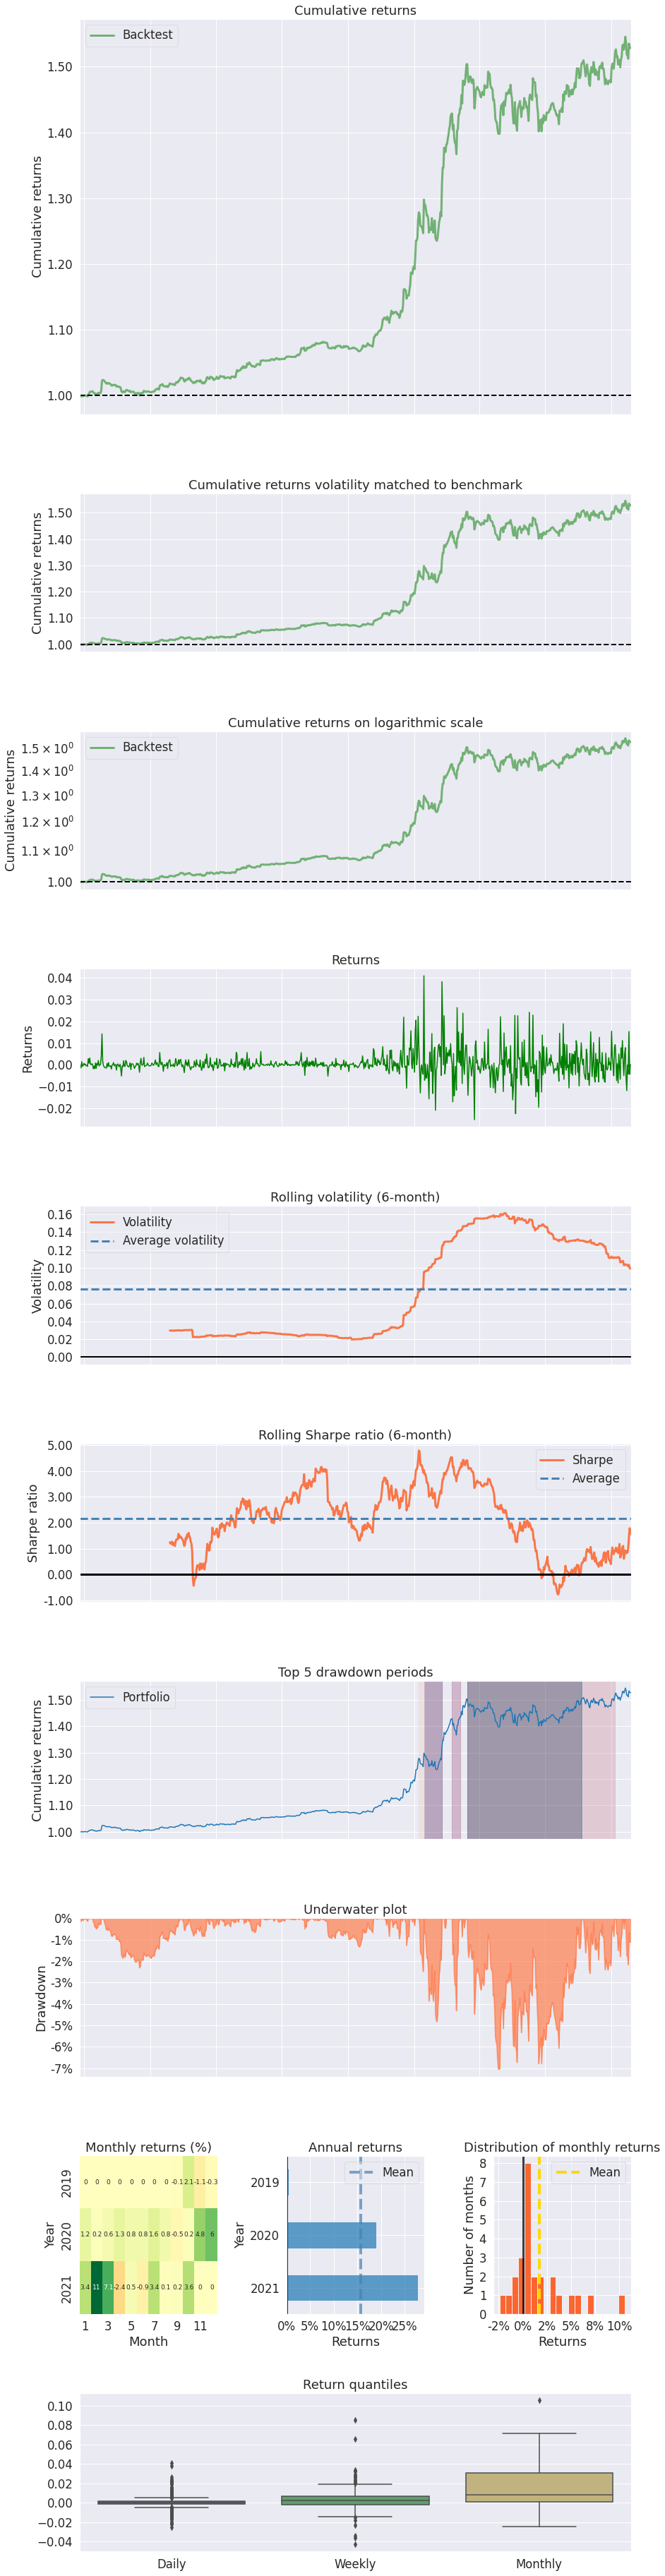

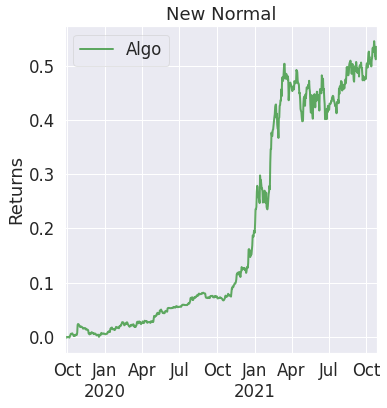

In [8]:
# backtrader 結果
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

# 把結果送進pyfolio
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# 輸出各種風險指標
pf.create_full_tear_sheet(returns)

## Optimize params
***
### Cutting row data Take 2021-01-01 as the boundary


In [ ]:
train = BTC_data[BTC_data.index < '2021-01-01 0:00:00']
test = BTC_data[BTC_data.index >= '2021-01-01 0:00:00']
train.to_csv(data_folder / "training_set.csv")
test.to_csv(data_folder / "testing_set.csv")

### Use optstrategy method
    Args:

        fast_period (int): fast ema period.
        slow_period (int): slow ema period.
        signal_period (int): macd signal period.


### 訓練集優化參數

In [26]:
BTC_train_data = pathlib.Path().cwd() / "data" / "training_set.csv"
cerebro = bt.Cerebro()

# 使用optstrategy調整參數
cerebro.optstrategy(
            zwpy_sta.MacdV2Strategy,
            fast_period = range(10,14),
            slow_period = range(24,28),
            signal_period = range(8,12))

# 設置初始資金
cerebro.broker.setcash(100000)

# 設定資料格式
dt_start = datetime.strptime("20190925","%Y%m%d")
dt_end = datetime.strptime("20211028","%Y%m%d")
data = bt.feeds.GenericCSVData(
    timeframe = bt.TimeFrame.Minutes,
    compression = 60,
    dataname=BTC_train_data,
    fromdate=dt_start,      
    todate=dt_end,
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S'),   
    datetime=0,          
    open = 1,
    high = 2,
    low = 3,
    close = 4,
    openinterest=-1,
    volume = -1
)
cerebro.adddata(data)

# 將backtrader回測結果放在各種analyzer中
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns")
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe", timeframe=bt.TimeFrame.Months)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()

# 將回測結果輸出成dataframe 並儲存csv檔
par_list = [[ele[0].params.fast_period, 
            ele[0].params.slow_period,
            ele[0].params.signal_period,
            ele[0].analyzers.returns.get_analysis()['rtot'], 
            ele[0].analyzers.sharpe.get_analysis()['sharperatio']
            ] for ele in results]
par_df = pd.DataFrame(par_list, columns = ['fast_period', 'slow_period', 'signal_period', 'return', 'sharpe'])
par_df.to_csv(report_folder / 'train_result.csv', index=False)


printlog:printlog: printlog:printlog: False  Falseprintlog:False
printlog:

 period_me1:period_me1:printlog:period_me1:False     10False
10printlog:10
FalseFalse

period_me1: period_me1:
period_me2:Falseperiod_me1:period_me2:   
 24
period_me2:10

10period_me1:24 
period_signal:
period_me1: period_me2: period_me2: 2410  9
10 25period_signal:


24
10

period_me2:
period_signal:  period_signal:period_signal:  825118period_me2:
 period_me2:

period_signal:10 

25
 25
=== Backtesting Start! ===period_signal:=== Backtesting Start! === 11=== Backtesting Start! ===

=== Backtesting Start! ===

period_signal:
 10=== Backtesting Start! ===
=== Backtesting Start! ===
 === Backtesting Start! ===
9

=== Backtesting Start! ===
=== Backtesting Finished! ====== Backtesting Finished! ===

=== Backtesting Finished! ====== Backtesting Finished! ===

=== Backtesting Finished! ====== Backtesting Finished! ===

=== Backtesting Finished! ===
=== Backtesting Finished! ===
printlog: False
period_me1: 10
perio

### 比較測試集與訓練集結果

In [24]:
BTC_test_data = pathlib.Path().cwd() / "data" / "testing_set.csv"
cerebro = bt.Cerebro()

# 使用optstrategy調整參數
cerebro.optstrategy(
            zwpy_sta.MacdV2Strategy,
            fast_period = range(10,14),
            slow_period = range(24,28),
            signal_period = range(8,12))

# 設置初始資金
cerebro.broker.setcash(100000)

# 設定資料格式
dt_start = datetime.strptime("20190925","%Y%m%d")
dt_end = datetime.strptime("20211028","%Y%m%d")
data = bt.feeds.GenericCSVData(
    timeframe = bt.TimeFrame.Minutes,
    compression = 60,
    dataname=BTC_test_data,
    fromdate=dt_start,      
    todate=dt_end,
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S'),   
    datetime=0,          
    open = 1,
    high = 2,
    low = 3,
    close = 4,
    openinterest=-1,
    volume = -1
)
cerebro.adddata(data)

# 將backtrader回測結果放在各種analyzer中
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns")
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe", timeframe=bt.TimeFrame.Months)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
par_list = [[ele[0].params.fast_period, 
            ele[0].params.slow_period,
            ele[0].params.signal_period,
            ele[0].analyzers.returns.get_analysis()['rtot'], 
            ele[0].analyzers.sharpe.get_analysis()['sharperatio']
            ] for ele in results]

# 將回測結果輸出成dataframe 並儲存csv檔
par_df = pd.DataFrame(par_list, columns = ['fast_period', 'slow_period', 'signal_period', 'return', 'sharpe'])
par_df.to_csv(report_folder / 'test_result.csv', index=False)


printlog:printlog:printlog:printlog:   printlog:printlog:False FalseFalse printlog:
printlog:
 FalseFalse
period_me1:False  period_me1:

period_me1: 
FalseFalse period_me1:period_me1:period_me1: 
1010 
 10
period_me1:
10
10 period_me1:period_me2: period_me2:period_me2:1010 
  
 24
period_me2:2410period_me2: period_me2:

24 
25 period_me2:period_signal:

2525 period_me2:period_signal:
9
  period_signal:period_signal: period_signal:
8 
25period_signal: 24 89 


11
10

=== Backtesting Start! ====== Backtesting Start! ====== Backtesting Start! ===
period_signal:period_signal:


=== Backtesting Start! === 11=== Backtesting Start! ===
=== Backtesting Start! === 

=== Backtesting Start! ===

10
=== Backtesting Start! ===
=== Backtesting Finished! ====== Backtesting Finished! ===

=== Backtesting Finished! ===
=== Backtesting Finished! ===
=== Backtesting Finished! ===
=== Backtesting Finished! ===
printlog: False
period_me1: 10
period_me2: 26
period_signal: 8
=== Backtesting Start! ====== Bac

In [25]:
train_result = pd.read_csv(report_folder / "train_result.csv")
test_result = pd.read_csv(report_folder / "test_result.csv")
print("traing_set\n", train_result,"\n","testing_set", test_result)
print(train_result['return'])

    fast_period  slow_period  signal_period    return    sharpe
0            10           24              8  0.164847  0.939718
1            10           24              9  0.169220  0.940869
2            10           24             10  0.170854  0.940938
3            10           24             11  0.177250  0.961053
4            10           25              8  0.166976  0.949345
..          ...          ...            ...       ...       ...
59           13           26             11  0.177715  0.978841
60           13           27              8  0.175432  0.935200
61           13           27              9  0.178255  0.971694
62           13           27             10  0.179246  0.971232
63           13           27             11  0.180953  0.963928

[64 rows x 5 columns] 
     fast_period  slow_period  signal_period    return    sharpe
0            10           24              8  0.274203  0.591322
1            10           24              9  0.299784  0.677059
2            10

### Result 
> **params : (fast_period, slow_period, signal_period)<br><br>
> default params (12,26,9) `profit` <font color="#f00">19378.88</font> <br><br>
> training set best params (11, 26, 10) `profit` <font color="#f00">19584.45</font><br><br>
> testing set best params (11, 26, 10) `profit` <font color="#f00">35346.14</font><br><br>**


### 比較預設參數＆最佳參數在訓練集的表現

<IPython.core.display.Javascript object>


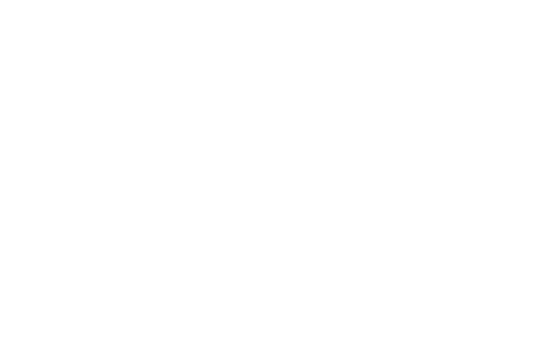

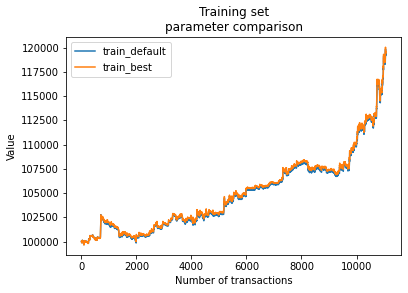

In [32]:
import matplotlib.pyplot as plt

timeseries = report_folder / "time_series.json"
with open(timeseries)as f:
    timeseries = json.load(f)
# make data
# print(timeseries)
y1 = timeseries['train_default']
y2 = timeseries['train_best']
y3 = timeseries['test_default']
y4 = timeseries['test_best']

# plot
plt.plot(range(len(y1)),y1, label="train_default")
plt.plot(range(len(y2)),y2, label="train_best")
plt.xlabel('Number of transactions')
plt.ylabel('Value')
plt.title('Training set\nparameter comparison')
plt.legend()
plt.show()


### 比較預設參數＆最佳參數在測試集的表現

<IPython.core.display.Javascript object>


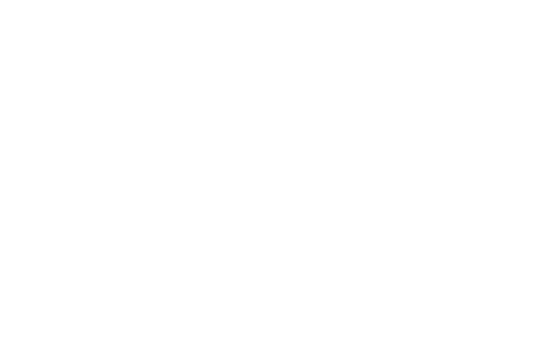

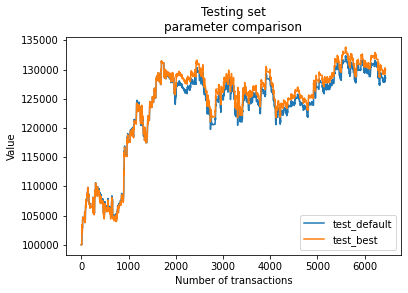

In [34]:
plt.plot(range(len(y3)),y3, label="test_default")
plt.plot(range(len(y4)),y4, label="test_best")
plt.xlabel('Number of transactions')
plt.ylabel('Value')
plt.title('Testing set\nparameter comparison')
plt.legend()
plt.show()

### for loop to find the best sharp_ratio (3 parameters)

`重複上述步驟，尋找最佳參數條件為獲取最佳sharp ratio`<br><br>
`train_sharp.py`<br><br>
**最佳參數亦為（11,26,10）**

In [ ]:
train_result = pd.read_csv(report_folder / "train_result")
test_result = pd.read_csv(report_folder / "test_result")